In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import os


In [2]:
os.chdir('C:/Users/danis/Documents/AAA4toSemestre IDM/PISA/PISA_NUEVO')

# Leer el archivo CSV
df = pd.read_csv('data/serie_temporal_semana.csv', parse_dates=['user_ts__'], index_col='user_ts__')


In [3]:
print("Columnas disponibles:\n", df.columns.tolist())
print("Primeras filas del dataset:\n", df.head())


Columnas disponibles:
 ['energyPerPreform_ActualTemperatureCoolingCircuit2.0', 'energyPerPreform_CurrentPreformNeckFinishTemperature.0', 'energyPerPreform_CurrentPreformTemperatureOvenInfeed.0', 'energyPerPreform_CurrentTemperatureRotaryJoint.0', 'numberOfActivatedRadiators_ActualTemperatureCoolingCircuit2.0', 'numberOfActivatedRadiators_CurrentPreformNeckFinishTemperature.0', 'numberOfActivatedRadiators_CurrentPreformTemperatureOvenInfeed.0', 'numberOfActivatedRadiators_CurrentTemperatureRotaryJoint.0', 'powerPerPreform_ActualTemperatureCoolingCircuit2.0', 'powerPerPreform_CurrentPreformNeckFinishTemperature.0', 'powerPerPreform_CurrentPreformTemperatureOvenInfeed.0', 'powerPerPreform_CurrentTemperatureRotaryJoint.0', 'value_ActualTemperatureCoolingCircuit2.0', 'value_CurrentPreformNeckFinishTemperature.0', 'value_CurrentPreformTemperatureOvenInfeed.0', 'value_CurrentTemperatureBrake.1', 'value_CurrentTemperatureBrake.2', 'value_CurrentTemperaturePressureDewPoint.0', 'value_CurrentTem

In [4]:
print("\nValores nulos por columna antes de limpieza:\n", df.isnull().sum())


Valores nulos por columna antes de limpieza:
 energyPerPreform_ActualTemperatureCoolingCircuit2.0                 186138
energyPerPreform_CurrentPreformNeckFinishTemperature.0              170402
energyPerPreform_CurrentPreformTemperatureOvenInfeed.0              188591
energyPerPreform_CurrentTemperatureRotaryJoint.0                    188133
numberOfActivatedRadiators_ActualTemperatureCoolingCircuit2.0       186138
numberOfActivatedRadiators_CurrentPreformNeckFinishTemperature.0    170402
numberOfActivatedRadiators_CurrentPreformTemperatureOvenInfeed.0    188591
numberOfActivatedRadiators_CurrentTemperatureRotaryJoint.0          188133
powerPerPreform_ActualTemperatureCoolingCircuit2.0                  186138
powerPerPreform_CurrentPreformNeckFinishTemperature.0               170402
powerPerPreform_CurrentPreformTemperatureOvenInfeed.0               188591
powerPerPreform_CurrentTemperatureRotaryJoint.0                     188133
value_ActualTemperatureCoolingCircuit2.0             

In [5]:
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

C:\Users\danis\AppData\Local\Temp\ipykernel_12640\3964524321.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\danis\AppData\Local\Temp\ipykernel_12640\3964524321.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [6]:
print("\nValores nulos por columna después de limpieza:\n", df.isnull().sum())


Valores nulos por columna después de limpieza:
 energyPerPreform_ActualTemperatureCoolingCircuit2.0                 0
energyPerPreform_CurrentPreformNeckFinishTemperature.0              0
energyPerPreform_CurrentPreformTemperatureOvenInfeed.0              0
energyPerPreform_CurrentTemperatureRotaryJoint.0                    0
numberOfActivatedRadiators_ActualTemperatureCoolingCircuit2.0       0
numberOfActivatedRadiators_CurrentPreformNeckFinishTemperature.0    0
numberOfActivatedRadiators_CurrentPreformTemperatureOvenInfeed.0    0
numberOfActivatedRadiators_CurrentTemperatureRotaryJoint.0          0
powerPerPreform_ActualTemperatureCoolingCircuit2.0                  0
powerPerPreform_CurrentPreformNeckFinishTemperature.0               0
powerPerPreform_CurrentPreformTemperatureOvenInfeed.0               0
powerPerPreform_CurrentTemperatureRotaryJoint.0                     0
value_ActualTemperatureCoolingCircuit2.0                            0
value_CurrentPreformNeckFinishTemperature

In [7]:
df = df.select_dtypes(include=[np.number])

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df)

In [9]:
print("\n¿Hay NaN después de escalar?:", np.isnan(data_scaled).sum())



¿Hay NaN después de escalar?: 0


In [10]:
def create_multivariate_dataset(dataset, look_back=3):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :].flatten())  # Aplanar para redes densas
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

look_back = 3
X, y = create_multivariate_dataset(data_scaled, look_back)


In [11]:

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)
plt.show()


Shape de X: (192835, 57)
Shape de y: (192835, 19)


In [12]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [13]:
print("\nNaN en X_train:", np.isnan(X_train).sum())
print("NaN en y_train:", np.isnan(y_train).sum())



NaN en X_train: 0
NaN en y_train: 0


In [14]:
imputer_X = SimpleImputer(strategy="most_frequent")
X_train = imputer_X.fit_transform(X_train)
X_test = imputer_X.transform(X_test)

imputer_y = SimpleImputer(strategy="most_frequent")
y_train = imputer_y.fit_transform(y_train)
y_test = imputer_y.transform(y_test)


In [27]:
n_features = df.shape[1]

from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(df.shape[1]))

c:\Users\danis\Documents\AAA4toSemestre IDM\PISA\Pisa_nuevo\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')

history = model.fit(X_train, y_train, epochs=200, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/200
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0370 - val_loss: 4.3313e-04
Epoch 2/200
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0094 - val_loss: 3.1523e-04
Epoch 3/200
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0080 - val_loss: 2.4898e-04
Epoch 4/200
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0073 - val_loss: 2.3928e-04
Epoch 5/200
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0070 - val_loss: 2.3807e-04
Epoch 6/200
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0068 - val_loss: 2.1392e-04
Epoch 7/200
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0067 - val_loss: 2.1502e-04
Epoch 8/200
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0067 - val_loss: 2.4607e-04
Epoch 9/200
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0065 - val_loss: 2.0373e-04
Epoch 10/200
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0064 - val_loss: 2.1292e-04
Epoch 11/200
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.006

In [29]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

4821/4821 ━━━━━━━━━━━━━━━━━━━━ 2s 508us/step
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step


In [30]:
train_pred_inv = scaler.inverse_transform(train_pred)
test_pred_inv = scaler.inverse_transform(test_pred)
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

In [31]:
print("Valores reales:\n", y_test_inv[:5])
print("Valores predichos:\n", test_pred_inv[:5])

Valores reales:
 [[  8.09000015   5.09000015   5.19000006  36.43000031  42.
   38.          42.         286.          78.62000275  49.47000122
   50.47999954 354.20001221  12.60000038  32.          22.
   26.70000076  26.60000038  -2.          33.90000153]
 [  8.09000015   5.09000015   5.19000006  36.43000031  42.
   38.          42.         286.          78.62000275  49.47000122
   50.47999954 354.20001221  12.60000038  31.          22.
   26.70000076  26.60000038  -2.          33.90000153]
 [  8.09000015   5.09000015   5.19000006  36.43000031  42.
   38.          42.         286.          78.62000275  49.47000122
   50.47999954 354.20001221  12.60000038  32.          22.
   26.70000076  26.60000038  -2.          33.90000153]
 [  8.09000015   5.09000015   5.19000006  36.43000031  42.
   38.          42.         286.          78.62000275  49.47000122
   50.47999954 354.20001221  12.60000038  31.          22.
   26.70000076  26.60000038  -2.          33.90000153]
 [  8.09000015   5.0900

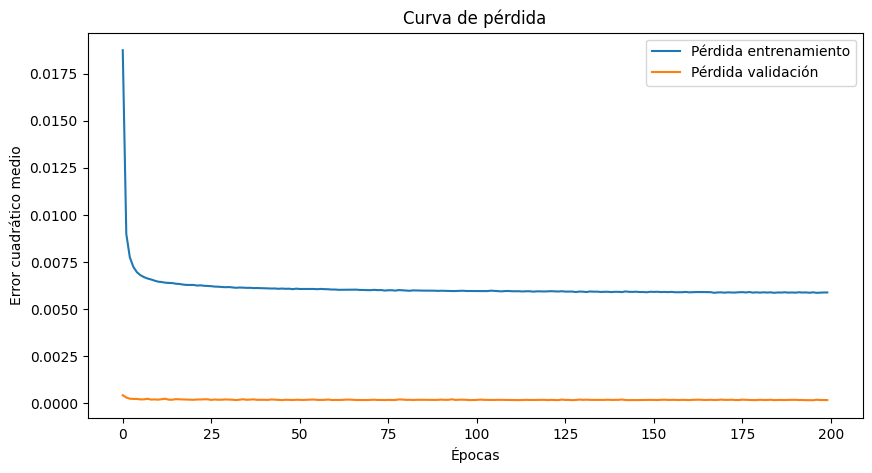

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Curva de pérdida')
plt.xlabel('Épocas')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.show()

In [33]:
vars_to_plot = df.columns[:3] 

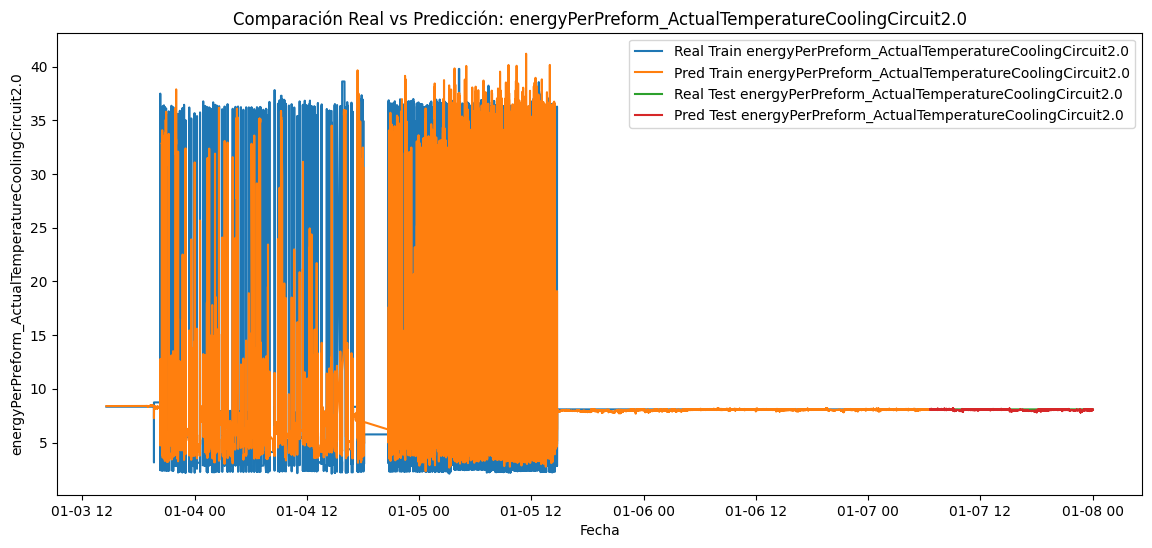

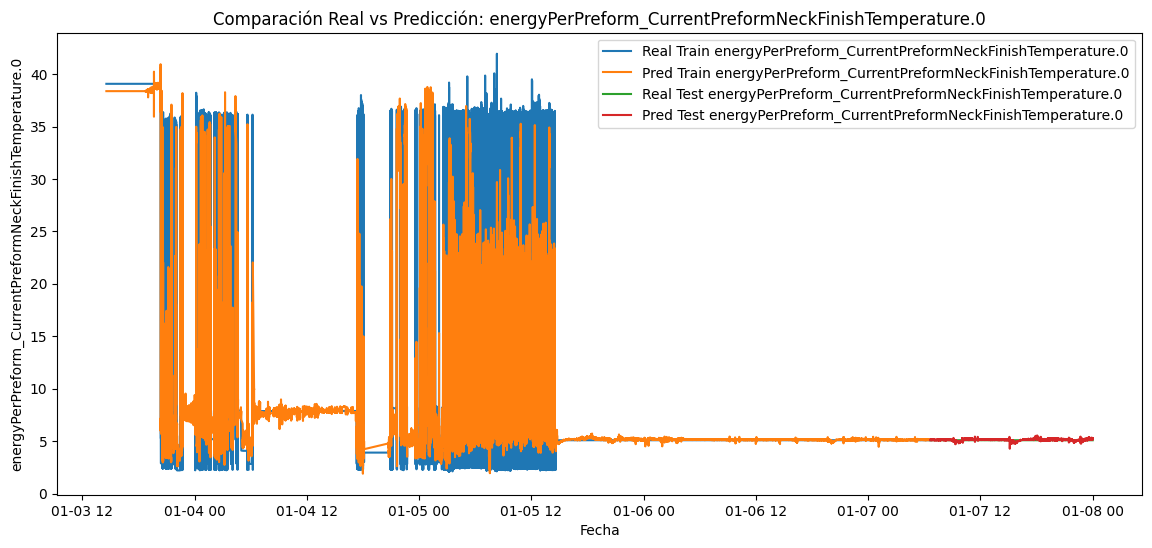

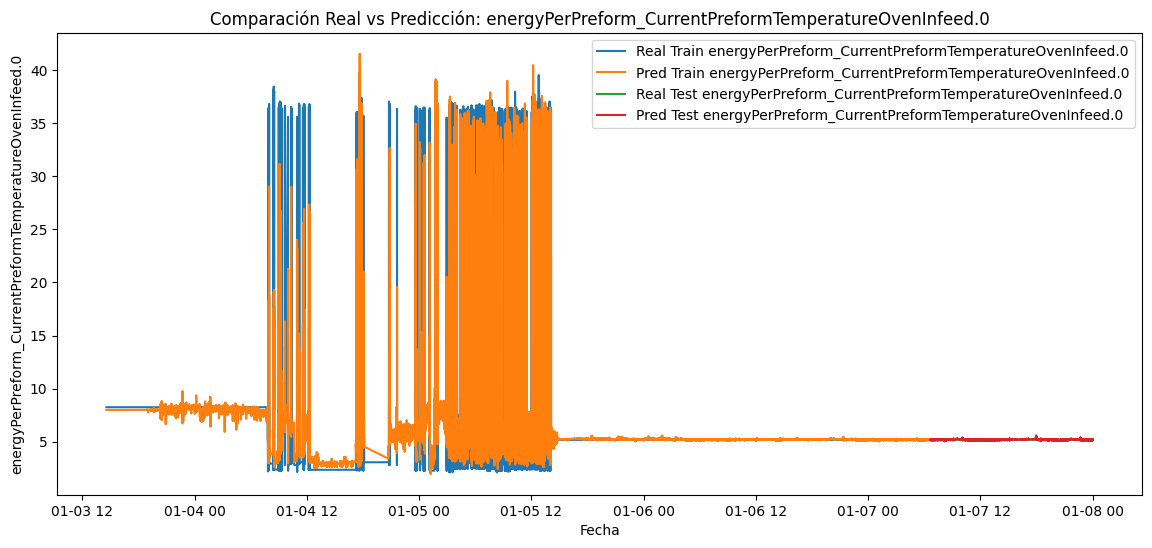

In [34]:
for i, var in enumerate(vars_to_plot):
    plt.figure(figsize=(14, 6))
    plt.plot(df.index[look_back:train_size + look_back], y_train_inv[:, i], label=f'Real Train {var}')
    plt.plot(df.index[look_back:train_size + look_back], train_pred_inv[:, i], label=f'Pred Train {var}')
    plt.plot(df.index[train_size + look_back:], y_test_inv[:, i], label=f'Real Test {var}')
    plt.plot(df.index[train_size + look_back:], test_pred_inv[:, i], label=f'Pred Test {var}')
    plt.title(f'Comparación Real vs Predicción: {var}')
    plt.xlabel('Fecha')
    plt.ylabel(var)
    plt.legend()
    plt.show()

In [35]:
last_data = data_scaled[-look_back:]
future_preds = []
future_steps = 10  # Número de pasos futuros

for _ in range(future_steps):
    input_data = last_data.flatten().reshape(1, -1)
    pred = model.predict(input_data)[0]
    future_preds.append(pred)
    last_data = np.vstack([last_data[1:], pred])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [36]:
future_preds_inv = scaler.inverse_transform(np.array(future_preds))
future_dates = pd.date_range(df.index[-1], periods=future_steps + 1, freq='D')[1:]


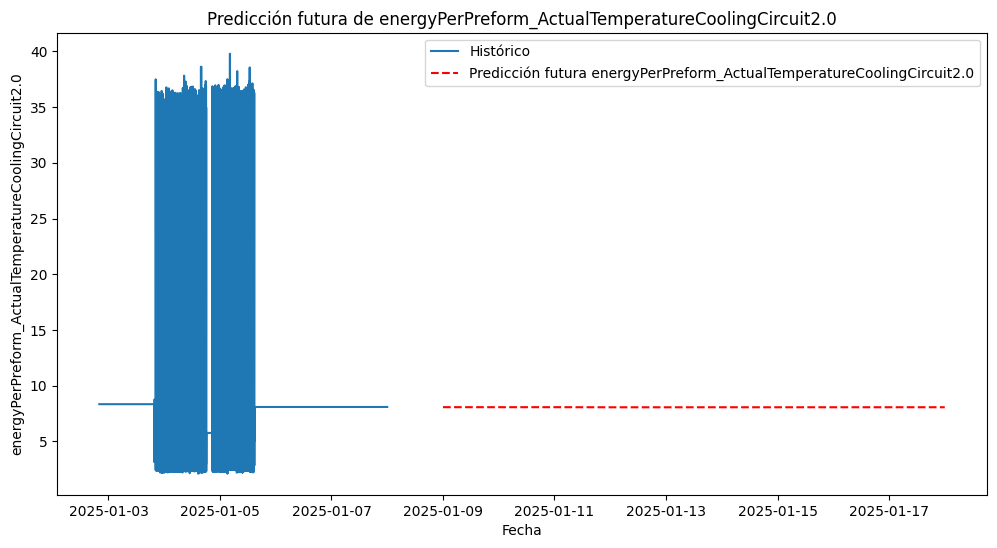

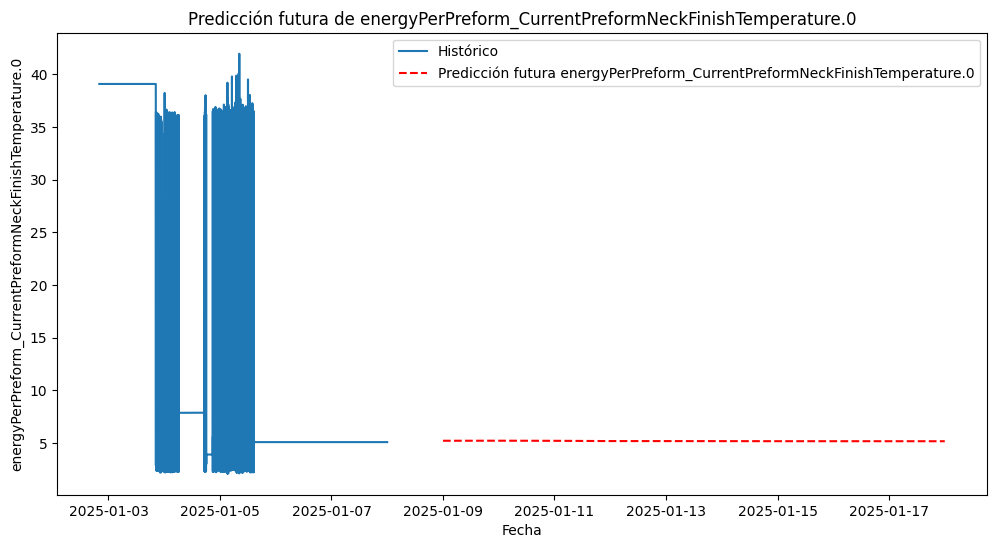

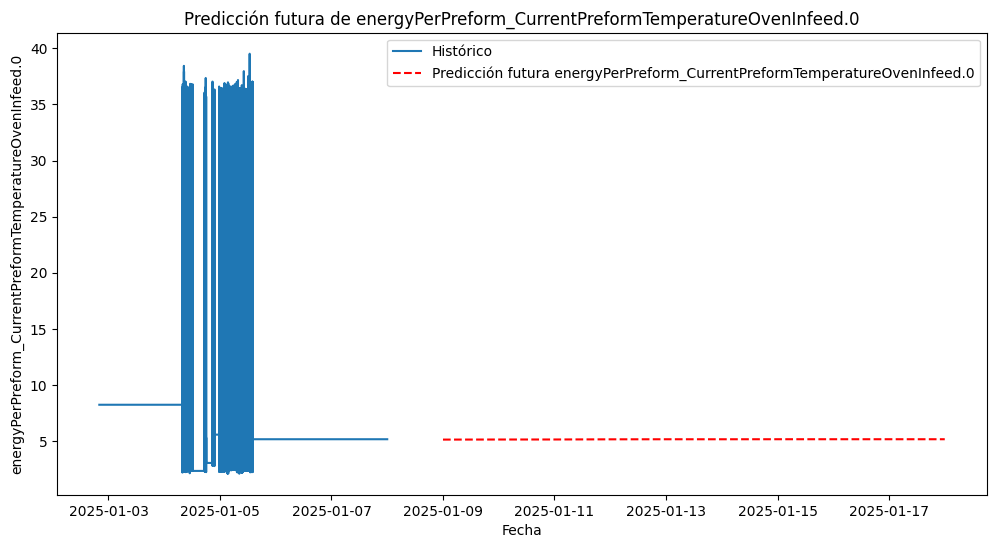

In [37]:
for i, var in enumerate(vars_to_plot):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[var], label='Histórico')
    plt.plot(future_dates, future_preds_inv[:, i], 'r--', label=f'Predicción futura {var}')
    plt.title(f'Predicción futura de {var}')
    plt.xlabel('Fecha')
    plt.ylabel(var)
    plt.legend()
    plt.show()